# PVD-D Benchmark #

The **Pressure Vessel Design** problem (PVD-D) is an engineering scenario that involves finding the optimal design parameters for a pressure vessel to meet specified performance criteria while minimizing costs.\
Without going into too much detail about the engineering framework we have the following variables:
<img src="./images/pvd_diagram.png" alt="alternative text" width="350"/>
$R$ is the radius for both the cilinder and the head, $L$ is the length of the cilinder, $T_h$ and $T_s$ are the thickness of the cilinder and the head respectively.\
Formally the problem can be stated as a minimization problem for the function:

$$f(T_s,T_h,R,L)=0.6224 \cdot T_s \cdot R \cdot L + 1.7781 \cdot T_h \cdot R^2 + 3.1611 \cdot T_s^2 \cdot L+19.84 \cdot Ts^2 \cdot R $$\
while also satistfying the following constraints:\
$$
\begin{align*}
-T_h + 0.0193R &\leq 0 \\
-T_s + 0.00954R &\leq 0 \\
-\pi R^2L - \frac{4}{3}\pi R^3 + 1296000 &\leq 0 \\
R-10 &\geq 0 \\
L-200 &\leq 0 \\
\end{align*}
$$

Moreover, we have that $T_h$ and $T_s$ are **discrete variables** that can assume only values in 
$\{0.0625\cdot i | i =1,2,\dots,99 \}$

### Theoretical best result ###
As proved in X.Yang, C. Huyck, M. Karamanoglu, N. Khan, *True Global Optimality of the Pressure Vessel Design
Problem: A Benchmark for Bio-Inspired Optimisation Algorithms* this problem as an **exact solution** of $$6059.714335048436$$ in $[0.8125, 0.4375, 42.0984455958549, 176.6365958424394]$.\
As presented in the paper above, a number of algorithms during the years reached values that are very close to the optimal solution.

## Modified GA-PSO ##

The algorithm we tested presents some differences with respect to the one presented in the previous notebooks.\
The main difference lies in the substitution of the stakes (i.e. a list) with a **matrix**. Since our discrete space is only in two dimensions we can efficiently divide it in $100$ **bins** (every dimension is divided into ten bins of equal size) and store in a matrix the continuous part (and the value) of the historical best particle whose discrete coordinates are contained in the bin. \
The idea is that in PSO a particle is attracted (in terms of continuous values) both to the absolute best particle and to the historical particle in the bin with the best value.\
This approach was not feasible in the previous applications since the discrete space was highly dimensional.



## Notes regarding the handling of the constraints ##
The most prominent difference of this problem when compared with the artificial functions in the previous notebooks is the presence of **constraints**. There exists many methods for both PSO and GA to handle constraints, an example of this can be assigning an arbitrary big value to the individuals which do not fulfil the constraints.\
In our experiments two strategies were tested:
* In the first case when an individual is modified (by PSO or mutation) and the modified individual is not fulfilling the constraint we simply **mantain** the original individual (using therefore only one constraint evaluation)
* in the second case we **repeat** the modification (with random values generated again) until we obtain a valid individual (using therefore many constraint evaluation for a single modification).

For crossover in both the version we use the second strategy.

The choice of the strategy depends on the properties of the problem such as the **cost for constraint vs the cost for evaluation** and the probability of generating invalid individuals.\
In the case of PVD-D the constraint evaluation is a bit more costly than the function evaluation. 

## Comparison of some algorithms ##

The following picture, taken from F. Wang, H. Zhang, A. Zhou *A particle swarm optimization algorithm for mixed-variable optimization problems*, compares some algorithms on the problem (best result [?] over 30 runs, for more information see the paper).

<img src="./images/pvd_alg_comp.png" alt="alternative text" width="500"/>

## Results ##
In this section the results for different values of $PSO\_it$ are reported with both strategies. Population size was set to $100$. Some parameters (e.g. size of the mutations) were tuned manually.\

When using the **mantain strategy** the results are the following on 30 independent runs (note that the two plots have different scales):
<img src="./images/pvd_no_admit.png" alt="alternative text" width="800"/>

And the **ratio of comparisons** is the following
<img src="./images/c_eval_no.png" alt="alternative text" width="350"/>


When using the **repeat strategy** the results are the following (note that the two plots have different scales):
<img src="./images/pvd_3way_admit.png" alt="alternative text" width="800"/>

And the **ratio of comparisons** is the following
<img src="./images/c_evals.png" alt="alternative text" width="350"/>

The **main takeaway** from these results is that the PSO part of the algorithm slows down the convergence at the beginning but is necessary to reach values closer to the optimal. Using only GA operators no values under $6090$ was reached in our tests, despite obtaining slightly better results on average.\
Overall the best results found by the above runs was (in general not very precise on the continuous part given python arithmetic, sometimes during trials reached values slightly below the theoretical minimum):
$$6060.0637 $$


# Code ##

In [1]:
import math 
import numpy as np
import copy
import matplotlib.pyplot as plt

### Function evaluation and constraints ##

In [2]:
def PVD_D_func(Ts,Th,R,L):
    '''
    Calculate the fitness function
    '''
    return 0.6224*Ts*R*L+1.7781*Th*R**2+3.1611*(Ts**2)*L+19.84*(Ts**2)*R

In [3]:
def PVD_D_constraint(Ts,Th,R,L):
    '''
    Check the constraint for the problem (boundaries)
    '''
    constraint = False
    first_const = -Ts+0.0193*R
    second_const = -Th+0.00954*R
    third_const = -math.pi*(R**2)*L-(4/3)*math.pi*(R**3)+1296000 #+750.1728
    if first_const <=0 and second_const<=0 and third_const<=0 and Ts<=6.1875 and Ts>=0.0625 and Th<=6.1875 and Th>=0.0625 and R>=10 and R<=200 and L>=10 and L<=200:
        constraint = True
    return constraint    

def discrete_check(Ts,Th):
    '''
    Check that Ts and Th are of the correct type (discrete values)
    '''
    const = False
    Ts1=Ts*10000
    Th1=Th*10000
    r_s = Ts1 % 625
    r_h = Th1 % 625
    if r_s==0 and r_h==0:
        const = True
    return const    

def PVD_D(Ts,Th,R,L,printing='no'):
    '''
    function that check all the constraint and returns the result of the fitness 
    '''
    discrete = discrete_check(Ts,Th)
    if discrete==False and printing=='yes':
        print('Not discrete')
    boundaries=PVD_D_constraint(Ts,Th,R,L)
    if boundaries==False and printing=='yes':
        print('Not acceptable')
    if discrete==True and boundaries==True:
        result=PVD_D_func(Ts,Th,R,L)
        return result    

### Initialization and population evaluation ##

In [4]:
def disc_rand_gen(tp):
    '''
    Generates uniformly at random values for Ts and Th
    '''
    if tp=='s':
        rnd=np.random.randint(0,98)
        res=0.0625+rnd*0.0625
    if tp=='h':
        rnd=np.random.randint(0,98)
        res=0.0625+rnd*0.0625
    return res

In [5]:
def initialization(n,c_eval):
    '''
    Initializes at random the population
    '''
    population=[]
    while len(population)<n:
        c_eval+=1
        first=disc_rand_gen('s')
        second=disc_rand_gen('h')
        third=np.random.uniform(10,200,1)[0]
        fourth=np.random.uniform(10,200,1)[0]
        
        #add the element to the list if the constraints are satisfied
        if PVD_D_constraint(first,second,third,fourth)==True:
            population+=[[first,second,third,fourth]]
            
    population=np.array(population)
    return population,c_eval

In [6]:
def evaluation(pop,fit_eval,max_fitness_eval):
    values=[]
    for i in range(0,len(pop)):
        fit_eval+=1
        if fit_eval>=max_fitness_eval:
            #print('Maximum number of evaluation reached')
            break
        Ts,Th,R,L = pop[i]
        values+=[PVD_D(Ts,Th,R,L,printing='no')]
    return values, fit_eval    
    

### Bin management ##

In [7]:
def bin_initialization():
    '''
    Initialize bins
    '''
    matrix = np.empty((10, 10), dtype=object)
    for i in range(10):
        for j in range(10):
            matrix[i, j] = [0, 0,1000000]
            
    return matrix        
    

In [8]:
def fill_bins(population,values,matrix):
    '''
    Update bins given the current population
    '''
    for q in range(0,len(population)):
        i=int(((population[q][0]-0.0625)//0.0625)//10)
        j=int(((population[q][1]-0.0625)//0.0625)//10)
        
        if values[q]<matrix[i,j][2]: 
            #better value than the current best for the bin
            matrix[i,j][2]=values[q]
            matrix[i,j][0]=population[q][2]
            matrix[i,j][1]=population[q][3]
    return matrix    
            

## Evolutionary process ##

In [9]:
def selection(n_pop, population, values):
    '''
    Performs the described selection
    '''
    #sorting population-values based on values
    sort_indices = np.argsort(values)
    population_sorted = population[sort_indices]
    values_sorted = np.sort(values)
    
    #top 1/5 (approx)
    twenty = int(np.floor(n_pop/5))
    population_20 = population_sorted[:twenty]
    values_20 = values_sorted[:twenty]
    
    #tournament of size 3 among the rest of the elements. At the end of it we have half of the population
    ind=[]
    for _ in range(0,int(n_pop/2)-twenty):
            numbers = np.random.randint(twenty, n_pop, size=3)
            lower_number = np.min(numbers)
            ind+=[lower_number]
    
    #add the winners to the above 1/5
    population_keep=np.concatenate((population_20,population_sorted[ind]),axis=0)
    values_keep=np.concatenate((values_20,values_sorted[ind]),axis=0)
    
    #in the end two arrays of size n_pop/2, the first 1/5 is correctly ordered
    return population_keep,values_keep

In [10]:
def crossover(n_pop,population_k,c_eval):
    '''
    Performs the described crossover
    '''
    #select the best performing 1/10
    #crossover population is already ordered, at least the first 1/5
    ten = int(np.floor(n_pop/10))
    cross_pop=population_k[:ten]
    
    #perform crossover
    while len(cross_pop)<n_pop-ten:
        #three type of crossover
        type_cross=np.random.randint(0, 3)
        #select parents uniformly among the selected population 
        
        
        mom = np.random.randint(0,len(population_k))
        dad = np.random.randint(0,len(population_k))
        
        if type_cross==0: #performs discrete-continuous crossover
            #discrete part from a parent, continuous part from the other
            son1 = np.concatenate((population_k[mom][:2], population_k[dad][-2:]))
            son2 = np.concatenate((population_k[dad][:2], population_k[mom][-2:]))
            
        if type_cross==1: #performs double one point crossover
            #extract two pints for crossover
            cross_point_discr = np.random.randint(0,2)
            cross_point_cont = np.random.randint(0,2)
            
            son1 = np.concatenate((population_k[mom][:cross_point_discr],population_k[dad][cross_point_discr:2], 
                                   population_k[mom][2:2+cross_point_cont], population_k[dad][2+cross_point_cont:]))
            son2 = np.concatenate((population_k[dad][:cross_point_discr],population_k[mom][cross_point_discr:2],  
                                   population_k[dad][2:2+cross_point_cont], population_k[mom][2+cross_point_cont:]))
        
        if type_cross==2: #performs uniform crossover
            for i in range(0,4):
                mom_copy = np.copy(population_k[mom])
                dad_copy = np.copy(population_k[dad])
                son1 = np.copy(population_k[mom])
                son2 = np.copy(population_k[dad])

                # perform uniform crossover with the probability 0.75
                for i in range(len(population_k[mom])):
                    if np.random.rand() < 0.75:
                        # Swap components if the random value is less than crossover_prob
                        son1[i]=dad_copy[i]
                    if np.random.rand() < 0.75:
                        # Swap components if the random value is less than crossover_prob
                        son2[i]=mom_copy[i]
                             
        c_eval+=1    
        if PVD_D_constraint(son1[0] , son1[1], son1[2],son1[3])==True and PVD_D_constraint(son2[0] , son2[1], son2[2],son2[3])==True:
            cross_pop=np.concatenate((cross_pop,np.array([son1,son2])),axis=0)
           
    #cross pop should have exactly n_pop-n_pop/10 elements
    return cross_pop,c_eval

In [11]:
def mutation(pop,n_pop,c_eval,repeat):
    '''
    Performs the mutation
    '''
    not_mutated = int(np.floor(n_pop)/10)
    
    for index in range(0,len(pop)):
        #keep the first not_mutated elements without mutations
        if index>=not_mutated:
            sub=False
            while sub==False:
                if repeat=='no': #no repetition mode
                    sub=True
                candidate=np.copy(pop[index])
                #three types of mutations/perturbation
                type_mut=np.random.randint(0, 3)
                #only discrete part
                if type_mut==0:
                    for var in range(0,2):
                        shift=np.random.randint(-2, 2)
                        candidate[var]+=0.0625*shift 



                #only continuous part     
                if type_mut==1:
                    for var in range(0,2):
                        fo = np.random.randint(-10, 10)
                        candidate[2+var]+=fo

                #both discrete and continuous     
                if type_mut==2:
                    for var in range(0,2):
                        shift=np.random.randint(-5, 5)
                        candidate[var]+=0.0625*shift
                    for var in range(0,2):
                        fo = np.random.randint(-2, 2)
                        candidate[2+var]+=fo
                c_eval+=1
                if PVD_D_constraint(candidate[0] , candidate[1], candidate[2],candidate[3]):
                        pop[index] = candidate
                        sub=True
                 
                    
                    
    
    for i in range(0,not_mutated):
        sub=False
        while sub==False:
            if repeat=='no': #no repetition mode
                    sub=True
            elite_mut = np.copy(pop[i])        
            c_eval+=1
            for var in range(0,2):
                is_changed = np.random.randint(0, 2)
                if is_changed==1:
                    shift=np.random.randint(-2, 2)
                    elite_mut[var]=elite_mut[var]+(0.0625)*shift 
            if PVD_D_constraint(elite_mut[0] , elite_mut[1], elite_mut[2],elite_mut[3]):
                pop=np.concatenate((pop, np.array([elite_mut])),axis=0)
                sub=True
            if  PVD_D_constraint(elite_mut[0] , elite_mut[1], elite_mut[2],elite_mut[3])==False and repeat=='no':
                pop=np.concatenate((pop, np.array([pop[i]])),axis=0)
                
    return pop,c_eval

### Particle Swarm Optimization ###

In [12]:
def PSO_bin(n_it,popo,best_v,best_pos,values,matrix, evals, max_fitness,c_eval,repeat, w=0.6,c_soc=1,c_cog=1.4,dim=2):
    '''
    Performs the PSO algorithm
    '''
    best_p=[best_pos[2],best_pos[3]]
    pop = np.hstack((popo, np.zeros((popo.shape[0], 2))))
    for j in range(0,n_it):
        for a in range(0,len(popo)):
            #find the bin corresponding to the current element
            i=int(((pop[a][0]-0.0625)//0.0625)//10)
            j=int(((pop[a][1]-0.0625)//0.0625)//10)
            sub=False
            trial=0
            while sub==False and trial<5:
                if repeat=='no':
                    sub=True
                r_1_1=np.random.uniform(0,1)
                r_1_2=np.random.uniform(0,1)
                r_2_1=np.random.uniform(0,1)
                r_2_2=np.random.uniform(0,1)
                #update velocities using the best element for that bin
                pop[a][4]=w*pop[a][4]+c_soc*(r_1_1*(best_p[0]-pop[a][2]))+c_cog*(r_2_1*(matrix[i,j][0]-pop[a][2]))
                pop[a][5]=w*pop[a][5]+c_soc*(r_1_2*(best_p[1]-pop[a][3]))+c_cog*(r_2_2*(matrix[i,j][1]-pop[a][3]))

                #update the particle only if the results satysfies the constraints 
                c_eval+=1
                trial+=1
                if PVD_D_constraint(pop[a][0],pop[a][1],pop[a][2]+pop[a][4],pop[a][3]+pop[a][5])==True:
                    pop[a][2]=pop[a][2]+pop[a][4]
                    pop[a][3]=pop[a][3]+pop[a][5]
                    sub=True
                
                
        for k in range(0,len(popo)):
            #evaluations
            evals+=1
            if evals> max_fitness:
                #print('Maximum number of evaluation reached')
                return pop,values,min(values),pop[np.argmin(values)],matrix,evals,c_eval
            Ts,Th,R,L,v1,v2 = pop[k]
            temp=PVD_D(Ts,Th,R,L,printing='no')
            values[k]=temp
        
        #update of the bins
        matrix=fill_bins(pop,values,matrix)
        best_it_v=min(values)
        best_it_pos=pop[np.argmin(values)]
        
        #update of the best particle if needed
        if best_it_v<=best_v:
            best_p=[best_it_pos[2],best_it_pos[3]]
            best_v=best_it_v
    
    pop = pop[:, :-2]
    return pop,values,min(values),pop[np.argmin(values)],matrix,evals,c_eval



### Main function ###

In [13]:
#introducing bin
def solving_PVD_bin(n_particles,n_it,ep,max_fitness_eval=100000, epoch_step=2, printing='yes',not_mutated=3,repeat='no'):
    '''
    Main function.
    Outputs four vectors needed for printing the results
    '''
    #number of constraint evaluations
    c_eval=0
    
    #initialization
    population,c_eval = initialization(n_particles,c_eval)       
    
    #number of fitness evaluation
    f_eval = 0
    
    #evaluation
    values, f_eval = evaluation(population,f_eval,max_fitness_eval)
    
    #store the best of the population    
    best_value, best = min(values),population[np.argmin(values)]
    #print(best_value,best)
    past_best_value = best_value
    
    #initialize the bin matrix
    matrix = bin_initialization()
        
    #update the bin matrix given the initial population
    matrix = fill_bins(population,values,matrix)
    
    #utilities for printing
    store_best=[best_value]
    f_store=[f_eval]
    c_store=[c_eval]
    e_store=[0]
    
    #main loop
    for epoch in range(0,ep):
                      
        #PSO
        population,values,best_value,best,matrix,f_eval,c_eval=PSO_bin(n_it,population,best_value,best,values,matrix,f_eval,max_fitness_eval,c_eval,repeat)
        
        if f_eval>=max_fitness_eval:
            #print('Epoch:',epoch)
            return store_best,f_store,c_store,e_store

        #selection
        pop_keep,values_keep = selection(n_particles, population,values)

        #crossover
        population,c_eval = crossover(n_particles,pop_keep,c_eval)

        #mutation
        population,c_eval = mutation(population,n_particles,c_eval,repeat)
        
        #evaluation
        values, f_eval = evaluation(population,f_eval,max_fitness_eval)
        
        if f_eval>=max_fitness_eval:
            #print('Epoch:',epoch)
            return store_best,f_store,c_store,e_store
        
        best_value, best = min(values),population[np.argmin(values)]
         
        if epoch%epoch_step==0:
            store_best+=[best_value]
            f_store+=[f_eval]
            c_store+=[c_eval]
            e_store+=[epoch]
    return store_best,f_store,c_store,e_store
        

## Code for the plots ##

In [ ]:
n_runs = 30

results_pvd_0=[]
space_pvd_0=[]
c0s=[]
for i in range(0,n_runs):
    res,space,c0,e0 = solving_PVD_bin(100,0,20000,max_fitness_eval=100000)
    results_pvd_0 += [res]
    space_pvd_0 = space
    c0s+=[c0]
        
results_pvd_0 = np.array(results_pvd_0)
c0s=np.array(c0s)


best_values_0 = np.min(results_pvd_0, axis=0)
mean_values_0 = np.mean(results_pvd_0, axis=0)
std_values_0 = np.std(results_pvd_0, axis=0)
c0s=np.min(c0s, axis=0)

results_pvd_5=[]
space_pvd_5=[]
c5s=[]
for i in range(0,n_runs):
    res,space,c5,e5 = solving_PVD_bin(100,5,200)
    results_pvd_5 += [res]
    space_pvd_5 = space
    c5s+=[c5]
        
results_pvd_5 = np.array(results_pvd_5)
c5s=np.array(c5s)



best_values_5 = np.min(results_pvd_5, axis=0)
mean_values_5 = np.mean(results_pvd_5, axis=0)
std_values_5 = np.std(results_pvd_5, axis=0)
c5s=np.min(c5s, axis=0)

results_pvd_10=[]
space_pvd_10=[]
c10s=[]
for i in range(0,n_runs):
    res,space,c10,e10 = solving_PVD_bin(100,10,200)
    results_pvd_10 += [res]
    space_pvd_10 = space
    c10s+=[c10]
        
results_pvd_5 = np.array(results_pvd_5)
c10s=np.array(c10s)


best_values_10 = np.min(results_pvd_10, axis=0)
mean_values_10 = np.mean(results_pvd_10, axis=0)
std_values_10 = np.std(results_pvd_10, axis=0)
c10s=np.min(c10s, axis=0)

In [15]:
def plot_vectors(vec1, vec2, vec3, vec4, vec5,vec6,vec7,vec8,vec9, vec10, vec11, vec12, function):
    #plotting the first set of vectors
    plt.figure(figsize=(11, 6))

    plt.subplot(1, 2, 1)
    plt.plot(vec4, vec1, 'x-', label='0-PSO', markersize=1,color='red')
    plt.plot(vec8, vec5, 'x-', label='5-PSO', markersize=1,color='blue')
    plt.plot(vec12, vec9, 'x-', label='10-PSO', markersize=1, color='green')
    plt.xlabel('Function evaluation')
    plt.ylabel('Best value found (lowest)')
    plt.title(f'Comparison best values on {function}')
    plt.legend()
    plt.grid(alpha=0.2)  
    plt.ylim(6000,6300) 

    #plotting the second set of vectors with error bars as semitransparent
    plt.subplot(1, 2, 2)
    plt.plot(vec4, vec2, 'x-', label='0-PSO',markersize=1, color='red')
    plt.fill_between(vec4, vec2 - vec3, vec2 + vec3, alpha=0.2, color='red', label='0-PSO std')
    plt.plot(vec8, vec6, 'x-', label='5-PSO',markersize=1, color='blue')
    plt.fill_between(vec8, vec6 - vec7, vec6 + vec8, alpha=0.2, color='blue', label='0-PSO std')
    plt.plot(vec12, vec10, 'x-', label='10-PSO',markersize=1, color='green')
    plt.fill_between(vec12, vec10 - vec11, vec10 + vec11, alpha=0.2, color='green', label='10-PSO std')
    plt.xlabel('Function evaluation')
    plt.ylabel('Best value found (mean)')
    plt.title(f'Comparison mean best values on {function}')
    plt.legend()
    plt.grid(alpha=0.2) 
    plt.ylim(6000,7500)  

    plt.tight_layout()
    plt.show()

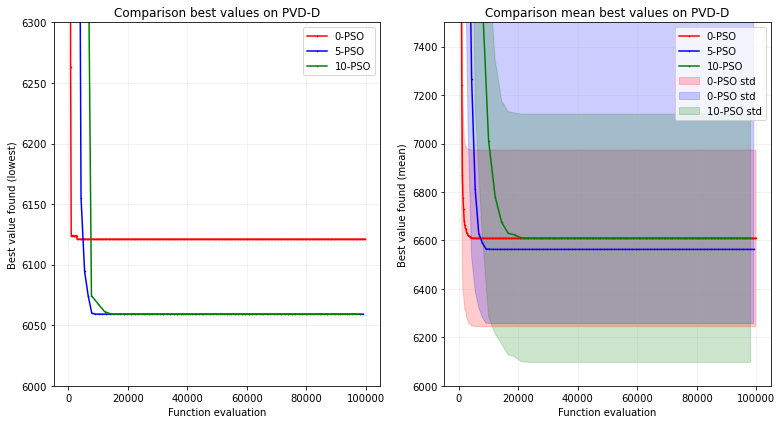

In [16]:
plot_vectors(best_values_0, mean_values_0, std_values_0, space_pvd_0,best_values_5, mean_values_5, std_values_5, space_pvd_5, best_values_10, mean_values_10, std_values_10, space_pvd_10,'PVD-D')

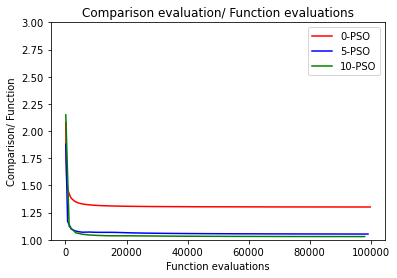

In [17]:
#plotting the ratio of constraints/function evalution

space_pvd_0 = np.array(space_pvd_0)
c0 = np.array(c0)
space_pvd_5 = np.array(space_pvd_5)
c5 = np.array(c5)
space_pvd_10 = np.array(space_pvd_10)
c10 = np.array(c10)

plt.plot(space_pvd_0,  c0s/space_pvd_0, label='0-PSO',c='red')

plt.plot(space_pvd_5,  c5s/space_pvd_5, label='5-PSO',c='blue')

plt.plot(space_pvd_10,  c10s/space_pvd_10 , label='10-PSO',c='green')


plt.xlabel('Function evaluations')
plt.ylabel('Comparison/ Function')
plt.title('Comparison evaluation/ Function evaluations')
plt.legend()
plt.ylim(1,3) 
plt.show()